In [1]:
import time
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import scipy.sparse
import sys
import pickle
import re
from pyitlib import discrete_random_variable as drv
from dtit import dtit
from scipy import stats
from numpy import savetxt
from numpy import genfromtxt
import networkx as nx
from scipy.stats import norm
import itertools
import math
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from pycm import *

In [2]:
def conditional_mutual_info(X,Y,Z=np.array(1)):
    
    if X.ndim == 1:
            X = np.reshape(X, (-1, 1))
    
    if Y.ndim == 1:
            Y = np.reshape(Y, (-1, 1))
            
    if Z.ndim == 0: 
        c1 = np.cov(X)
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
            
        c2 = np.cov(Y)
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(X,Y)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        cmi = (1/2)*np.log((d1*d2)/d3)
    
    else:
        
        if Z.ndim == 1:
            Z = np.reshape(Z, (-1, 1))
        
        c1 = np.cov(np.concatenate((X, Z), axis=0))
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
    
        c2 = np.cov(np.concatenate((Y, Z), axis=0))
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(Z)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        c4 = np.cov(np.concatenate((X, Y, Z), axis=0))
        
        if c4.ndim != 0: 
            d4 = np.linalg.det(c4)
        else:
            d4 = c4.item()
        
        cmi = (1/2)*np.log((d1*d2)/(d3*d4))
    
    
    if math.isinf(cmi):
        cmi = 0
    
    return cmi



In [3]:
def pca_cmi(data, theta, max_order):
    
    genes = list(data.columns)
    
    predicted_graph = nx.complete_graph(genes)
    num_edges = predicted_graph.number_of_edges()
    print("Number of edges in the initial complete graph : {}".format(num_edges))
    print()
    
    L = -1
    nochange = False
    
    while L < max_order and nochange == False:
        L = L+1
        predicted_graph, nochange = remove_edges(predicted_graph, data, L, theta)
        
        print("Order : {}".format(L))
        print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
        print()
    
    
    print()
    print()
    print("Final Prediction:")
    print("-----------------")
    print("Order : {}".format(L))
    print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
    nx.draw(predicted_graph, with_labels=True, font_weight='bold')
    print()
    return predicted_graph


def remove_edges(predicted_graph, data, L, theta):
    
    initial_num_edges = predicted_graph.number_of_edges()
    
    edges = predicted_graph.edges()

    for edge in edges:
        neighbors = nx.common_neighbors(predicted_graph, edge[0], edge[1])
        nhbrs = copy.deepcopy(sorted(neighbors))\
        
        T = len(nhbrs)
        
        if T < L and L != 0:
            continue
        
        else:
            x = data[edge[0]].to_numpy()
            if x.ndim == 1:
                x = np.reshape(x, (-1, 1))
            
            y = data[edge[1]].to_numpy()
            if y.ndim == 1:
                y = np.reshape(y, (-1, 1))
                
            K = list(itertools.combinations(nhbrs, L))
                
            if L == 0:
                cmiVal = conditional_mutual_info(x.T, y.T)
                
                if cmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                               
            else:  
                
                maxCmiVal = 0
                
                for zgroup in K:
                    
                    z = data[list(zgroup)].to_numpy()
                    if z.ndim == 1:
                        z = np.reshape(z, (-1, 1))
                    
                    cmiVal = conditional_mutual_info(x.T, y.T, z.T)
                    
                    if cmiVal > maxCmiVal:
                        maxCmiVal = cmiVal
                
                if maxCmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                    
                
        
    final_num_edges = predicted_graph.number_of_edges()
        
    if final_num_edges < initial_num_edges:
        return  predicted_graph, False
        
        
    return  predicted_graph, True
            

In [4]:
data = pd.read_csv('Data/InSilicoSize10-Yeast1-null-mutants.tsv', sep='\t')
data = data.drop(['strain'], axis=1)
data

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
0,0.529871,0.517426,0.818152,0.077024,0.514933,0.849380,0.446296,0.466263,0.862243,0.892563
1,0.010053,0.815176,0.845015,0.376999,0.248059,0.859406,0.474825,0.495988,0.641061,0.875929
2,0.510487,0.082249,0.942792,0.092006,0.501758,0.897611,0.426991,0.461354,0.915775,0.878408
3,0.794319,0.533865,0.000000,0.000000,0.714275,0.919026,0.462578,0.507089,0.907252,0.807122
4,0.533501,0.476569,0.852780,0.000000,0.577055,0.900193,0.509145,0.441179,0.862970,0.901971
5,0.549960,0.487726,0.945599,0.000000,0.000000,0.858854,0.849638,0.458988,0.906015,0.912500
6,0.460369,0.501849,0.917398,0.239301,0.522597,0.000000,0.545508,0.434083,0.751722,0.946483
7,0.427145,0.492922,0.884602,0.002402,0.520915,0.876362,0.000000,0.850223,0.832538,0.917185
8,0.513985,0.544410,0.859676,0.000000,0.554409,0.879938,0.443015,0.031132,0.903685,0.888021
9,0.533942,0.537358,0.896238,0.049496,0.579922,0.945879,0.417966,0.460969,0.000000,0.919536


Number of edges in the initial complete graph : 45

Order : 0
Number of edges in the predicted graph : 10

Order : 1
Number of edges in the predicted graph : 8

Order : 2
Number of edges in the predicted graph : 8



Final Prediction:
-----------------
Order : 2
Number of edges in the predicted graph : 8

[[0 0 1 1 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


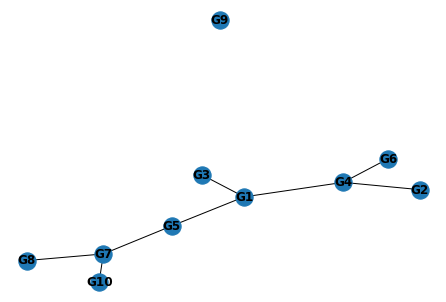

In [5]:
predicted_graph = pca_cmi(data, 0.05, 10)
predicted_adjMatrix = nx.adjacency_matrix(predicted_graph)

print(predicted_adjMatrix.todense())

In [6]:
benchmark_network = pd.read_csv('Test/DREAM3GoldStandard_InSilicoSize10_Yeast1.txt', sep='\t', header=None)
benchmark_network = benchmark_network.loc[benchmark_network[2] == 1]
benchmark_network

,0,1,2
0,G3,G1,1
1,G1,G2,1
2,G1,G4,1
3,G6,G4,1
4,G1,G5,1
5,G3,G5,1
6,G5,G7,1
7,G10,G7,1
8,G7,G8,1
9,G4,G9,1


[[0 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


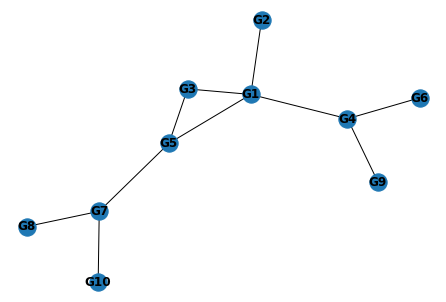

In [7]:
import matplotlib.pyplot as plt

benchmark_graph = nx.Graph()

for i in (1,10):
    benchmark_graph.add_node('G'+str(i))

for row in range(0,benchmark_network.shape[0]):
    benchmark_graph.add_edge(benchmark_network[0][row], benchmark_network[1][row])

nx.draw(benchmark_graph, with_labels=True, font_weight='bold')

benchmark_adjMatrix = nx.adjacency_matrix(benchmark_graph)

print(benchmark_adjMatrix.todense())

In [8]:
# editDistance = nx.optimize_graph_edit_distance(predicted_graph, benchmark_graph)
# print(list(editDistance))

In [9]:
y_test = benchmark_adjMatrix.todense().flatten()
y_pred = predicted_adjMatrix.todense().flatten()

y_pred = np.asarray(y_pred)
y_test = np.asarray(y_test)

y_pred = y_pred.reshape(y_pred.shape[1],)
y_test = y_test.reshape(y_test.shape[1],)

In [10]:
# ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred)
# auc = roc_auc_score(y_test, y_pred)

# # plot the roc curve for the model
# # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC')
# pyplot.plot(ns_fpr, ns_tpr, label='AUC='+str(round(auc*100,2))+'%')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

cm = ConfusionMatrix(y_test, y_pred)
# cm.relabel(mapping=classdict)
print(cm)

Predict  0        1        
Actual
0        72       8        

1        12       8        





Overall Statistics : 

95% CI                                                            (0.7216,0.8784)
ACC Macro                                                         0.8
ARI                                                               0.22897
AUNP                                                              0.65
AUNU                                                              0.65
Bangdiwala B                                                      0.74545
Bennett S                                                         0.6
CBA                                                               0.62857
CSI                                                               0.32857
Chi-Squared                                                       10.71429
Chi-Squared DF                                                    1
Conditional Entropy                                               0.56939
Cra

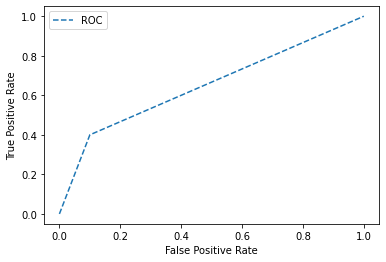

In [11]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()